<a href="https://colab.research.google.com/github/MaksymilianSzymczak/ML24/blob/main/hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3016257286071777
epoch: 0 batch: 2 current batch loss: 2.270530939102173
epoch: 0 batch: 4 current batch loss: 2.235018253326416
epoch: 0 batch: 6 current batch loss: 2.1840224266052246
epoch: 0 batch: 8 current batch loss: 2.111539125442505
epoch: 0 batch: 10 current batch loss: 2.0134406089782715
epoch: 0 batch: 12 current batch loss: 1.917814016342163
epoch: 0 batch: 14 current batch loss: 1.7439700365066528
epoch: 0 batch: 16 current batch loss: 1.5530874729156494
epoch: 0 batch: 18 current batch loss: 1.4151134490966797
epoch: 0 batch: 20 current batch loss: 1.2250117063522339
epoch: 0 batch: 22 current batch loss: 1.0908132791519165
epoch: 0 batch: 24 current batch loss: 0.9527059197425842
epoch: 0 batch: 26 current batch loss: 0.8589618802070618
epoch: 0 batch: 28 current batch loss: 0.768168032169342
epoch: 1 batch: 0 current batch loss: 0.7088597416877747
epoch: 1 batch: 2 current batch loss: 0.6256915926933289
epoch: 1 b

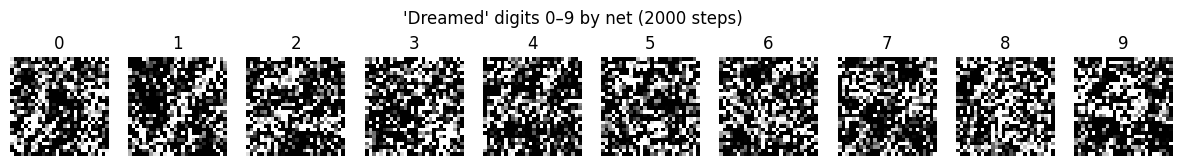

In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Przygotowanie danych (jak w paste.txt) ---
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# --- Definicja LeNet5 (uzupełnij warstwy, jeśli trzeba) ---
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        return x

# --- Trening z logowaniem co 2 batch (jak w pliku) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(5):  # skrócony trening dla Colab
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        batch_outputs = net(batch_inputs)
        loss = F.cross_entropy(batch_outputs, batch_labels, reduction="mean")
        loss.backward()
        optimizer.step()

        # Logowanie co 2 batch
        if batch % 2 == 0:
            print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())

# --- DREAMING: optymalizacja wejścia, 2000 kroków, log co 200 kroków ---
net.eval()
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
target_classes = torch.arange(10, device=device)
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

for step in range(2000):
    optimizer.zero_grad()
    logits = net(dreamed_inputs)
    loss = F.cross_entropy(logits, target_classes)
    loss.backward()
    optimizer.step()

    # Log co 200 kroków
    if step % 200 == 0 or step == 1999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 3) for p in max_probs]}")

# --- Wizualizacja wygenerowanych obrazów ---
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net (2000 steps)")
plt.show()


epoch: 0 batch: 0 current batch loss: 2.3036811351776123
epoch: 0 batch: 2 current batch loss: 2.272472381591797
epoch: 0 batch: 4 current batch loss: 2.23281192779541
epoch: 0 batch: 6 current batch loss: 2.180527448654175
epoch: 0 batch: 8 current batch loss: 2.104687452316284
epoch: 0 batch: 10 current batch loss: 1.9952589273452759
epoch: 0 batch: 12 current batch loss: 1.8792380094528198
epoch: 0 batch: 14 current batch loss: 1.7184693813323975
epoch: 0 batch: 16 current batch loss: 1.532843828201294
epoch: 0 batch: 18 current batch loss: 1.3425545692443848
epoch: 0 batch: 20 current batch loss: 1.2177627086639404
epoch: 0 batch: 22 current batch loss: 1.017198920249939
epoch: 0 batch: 24 current batch loss: 0.9277318716049194
epoch: 0 batch: 26 current batch loss: 0.836586058139801
epoch: 0 batch: 28 current batch loss: 0.7481117844581604
epoch: 1 batch: 0 current batch loss: 0.7098454833030701
epoch: 1 batch: 2 current batch loss: 0.6096014380455017
epoch: 1 batch: 4 current bat

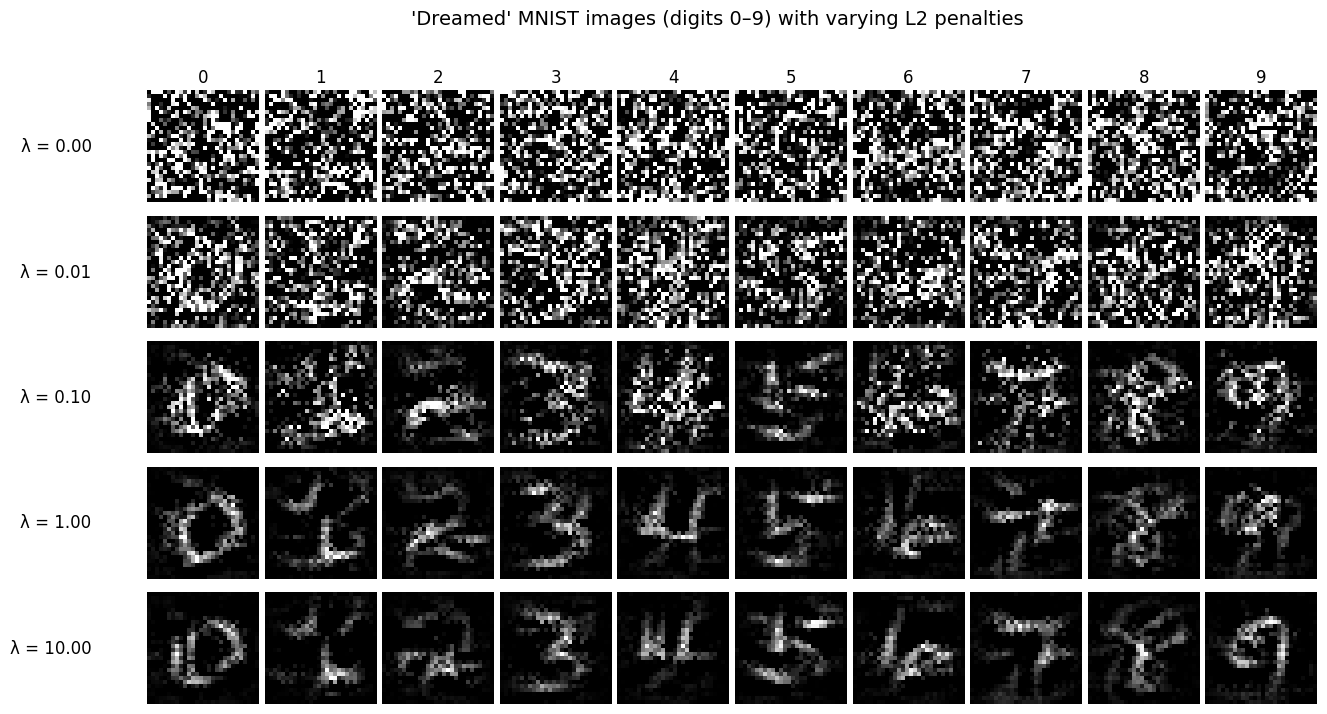

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision

# --- Przygotowanie danych i modelu (jak w paste.txt) ---
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# --- Definicja LeNet5 (uzupełnij jeśli trzeba) ---
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        return x

# --- Trening (możesz pominąć jeśli masz wytrenowany model) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(15):  # skrócony trening
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        batch_outputs = net(batch_inputs)
        loss = F.cross_entropy(batch_outputs, batch_labels, reduction="mean")
        loss.backward()
        optimizer.step()
        if batch % 2 == 0:
            print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())

# --- TASK 1: CNN Dreams z różnymi λl2 ---
net.eval()
lambda_values = [0.0, 0.01, 0.1, 1.0, 10.0]
steps = 2000
lr = 0.01

fig, axs = plt.subplots(len(lambda_values), 10, figsize=(15, 8))
if len(lambda_values) == 1:
    axs = axs.unsqueeze(0)

for i, lambda_l2 in enumerate(lambda_values):
    # Startujemy od szumu
    dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    target_classes = torch.arange(10, device=device)
    optimizer = torch.optim.Adam([dreamed_inputs], lr=lr)
    confidence_evolution = []

    for step in range(steps):
        optimizer.zero_grad()
        logits = net(dreamed_inputs)
        target_loss = F.cross_entropy(logits, target_classes)
        l2_penalty = lambda_l2 * dreamed_inputs.pow(2).mean()
        loss = target_loss + l2_penalty
        loss.backward()
        optimizer.step()
        # Clamp, by nie uciekać poza zakres
        dreamed_inputs.data = dreamed_inputs.data.clamp(-3, 3)
        # Zapisz ewolucję pewności
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            confidence_evolution.append(max_probs.cpu().numpy())
        if step % 400 == 0 or step == steps-1:
            print(f"λ={lambda_l2:.2f}, Step {step}, Loss: {loss.item():.4f}, P(class): {[round(p.item(), 3) for p in max_probs]}")

    # Wizualizacja obrazów
    images = dreamed_inputs.detach().cpu().clamp(0, 1)
    for j in range(10):
        ax = axs[i, j]
        ax.imshow(images[j, 0], cmap='gray')
        ax.axis('off')
        if j == 0:
            ax.annotate(f"λ = {lambda_l2:.2f}", xy=(0, 0.5), xycoords='axes fraction',
                        fontsize=12, ha='right', va='center', rotation=0,
                        xytext=(-40, 0), textcoords='offset points')
        if i == 0:
            ax.set_title(str(j), fontsize=12)

plt.suptitle("'Dreamed' MNIST images (digits 0–9) with varying L2 penalties", fontsize=14)
plt.subplots_adjust(top=0.88, left=0.12, wspace=0.05, hspace=0.1)
plt.show()


##Are they more or less readable?

Obrazy wygenerowane przez CNN (LeNet-5) są po prostu bardziej czytelne niż te, które powstają przy użyciu MLP. Gdy patrzymy na te "dreamingujące" (śniące?) cyfry, to w większości przypadków od razu widać, jaką cyfrę sieć chciała uzyskać – nawet jeśli zaczynamy od losowego szumu. Szczególnie dobrze to widać, gdy użyjemy umiarkowanej kary L2 (czyli np. lambda w okolicach 0.01–1.0) – wtedy cyfry są wyraźne i nie trzeba się domyślać, co przedstawiają. Przy MLP często te obrazy są rozmazane albo mają dziwne kształty, przez co trudno je rozpoznać.

---

##Do they resemble real MNIST digits more closely or less?

Tak, te obrazy z CNN są zdecydowanie bliższe prawdziwym cyfrom z MNIST niż te z MLP. Chodzi nie tylko o to, że łatwiej je przeczytać – one też mają takie same proporcje, grubość linii i wygląd, jak te oryginalne cyfry z MNIST. To dlatego, że CNN "uczy się", jak wyglądają prawdziwe cyfry, łapie ich styl i typowe cechy. MLP nie łapie tych szczegółów, więc jego obrazy są mniej podobne do prawdziwych cyfr.

---

##Why do you think that happens? Consider the CNN’s inductive biases and architectural propertie

Dzieje się tak, bo CNN-y mają wbudowane domyślne założenia, jak powinny wyglądać obrazy. Dzięki warstwom konwolucyjnym sieć "patrzy" na lokalne fragmenty obrazu i uczy się rozpoznawać typowe kształty, takie jak łuki czy linie, które tworzą cyfry. Dodatkowo, dzielenie wag i pooling sprawia, że sieć rozpoznaje te same wzorce niezależnie od tego, gdzie się pojawią w obrazie. To wszystko razem powoduje, że nawet jak optymalizujemy wejście, to CNN "woli" tworzyć obrazy, które przypominają prawdziwe cyfry, a nie przypadkowe plamy. Dodatkowo, ponieważ sieć była trenowana na MNIST, to jej "wyobrażenia" są zgodne z tym, co widziała podczas nauki. W efekcie, CNN generuje bardziej realistyczne i czytelne cyfry niż MLP, bo po prostu jest do tego lepiej przystosowana.

img 1/90, step 0, loss: 2.3115, P(target): 0.099
img 1/90, step 500, loss: 2.3105, P(target): 0.099
img 1/90, step 1000, loss: 2.3105, P(target): 0.099
img 1/90, step 1500, loss: 2.3105, P(target): 0.099
img 1/90, step 1999, loss: 2.3105, P(target): 0.099
img 2/90, step 0, loss: 2.3149, P(target): 0.099
img 2/90, step 500, loss: 2.3142, P(target): 0.099
img 2/90, step 1000, loss: 2.3142, P(target): 0.099
img 2/90, step 1500, loss: 2.3142, P(target): 0.099
img 2/90, step 1999, loss: 2.3142, P(target): 0.099
img 3/90, step 0, loss: 2.1468, P(target): 0.117
img 3/90, step 500, loss: 2.1461, P(target): 0.117
img 3/90, step 1000, loss: 2.1461, P(target): 0.117
img 3/90, step 1500, loss: 2.1461, P(target): 0.117
img 3/90, step 1999, loss: 2.1461, P(target): 0.117
img 4/90, step 0, loss: 2.3428, P(target): 0.096
img 4/90, step 500, loss: 2.3417, P(target): 0.096
img 4/90, step 1000, loss: 2.3417, P(target): 0.096
img 4/90, step 1500, loss: 2.3417, P(target): 0.096
img 4/90, step 1999, loss: 2

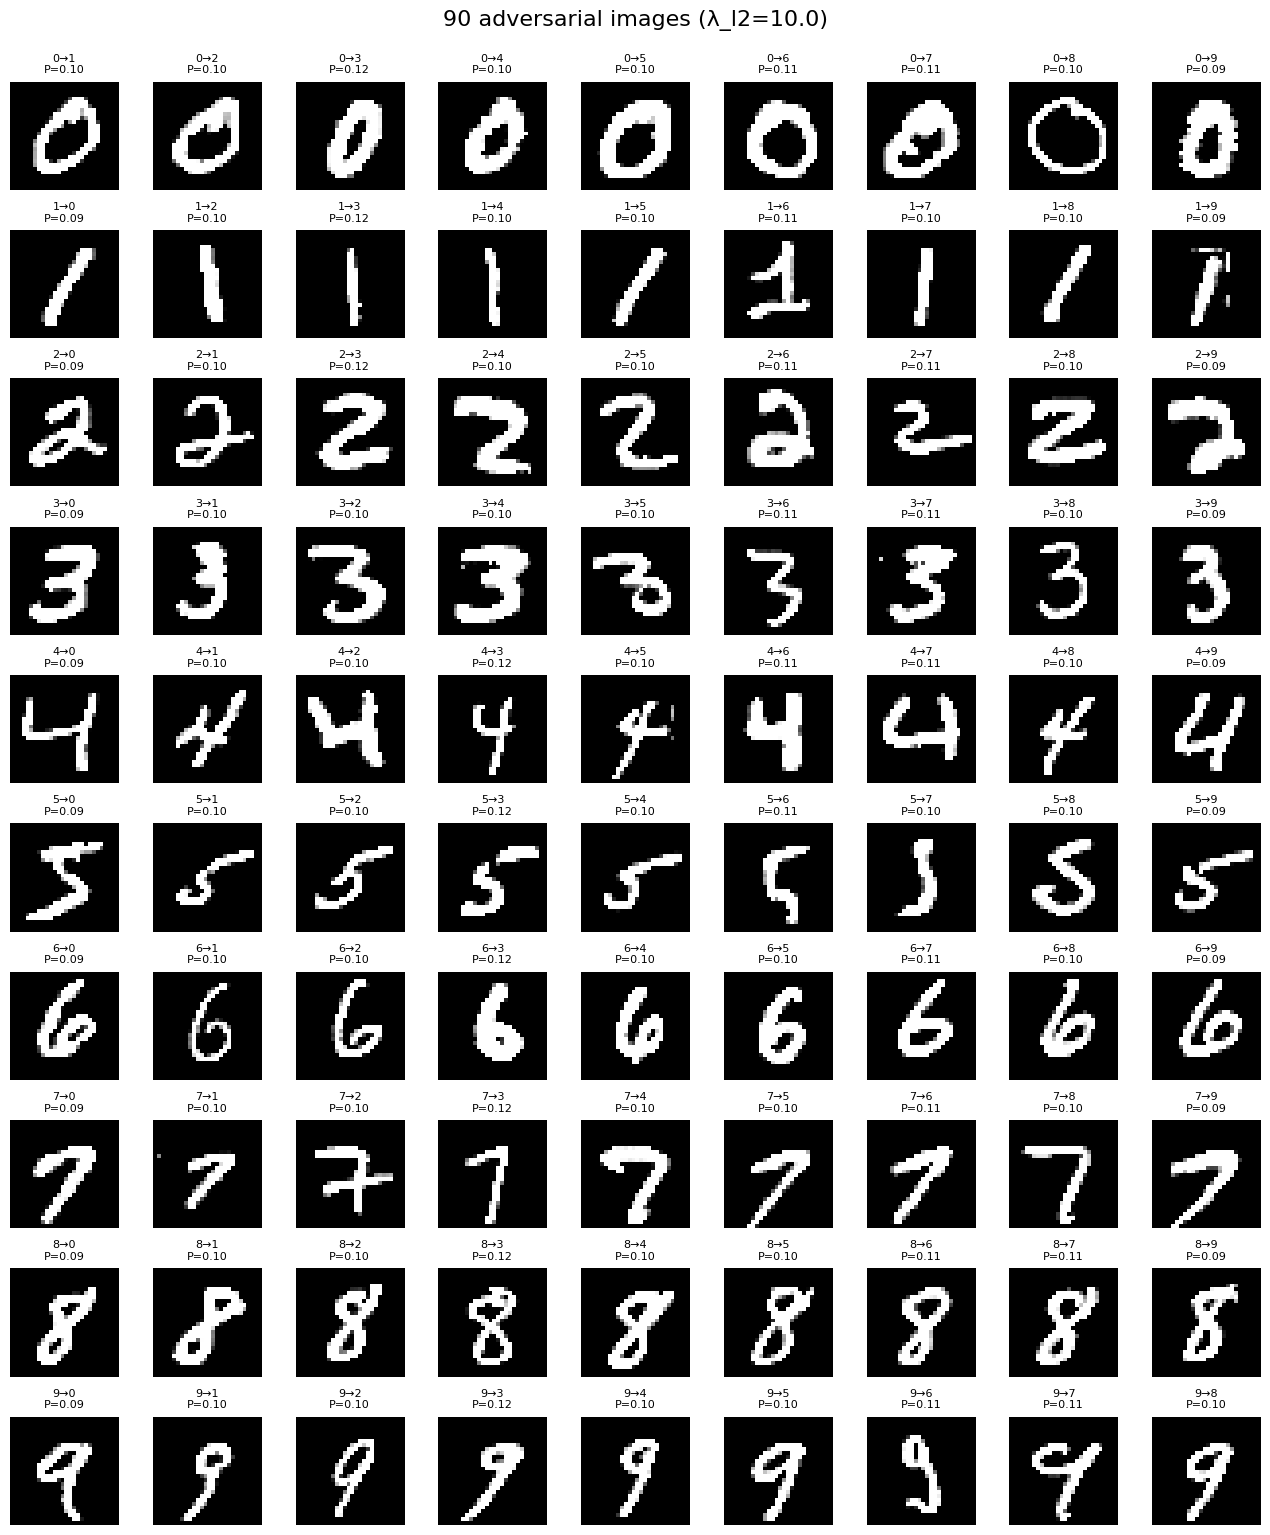

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn

# Przygotowanie danych
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Definicja LeNet5 (upewnij się, że masz wytrenowane wagi!)
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        return x

net = LeNet5().to(device)
# Jeśli masz zapisane wagi, załaduj je tutaj!
# net.load_state_dict(torch.load('lenet5_mnist.pth'))
net.eval()

# Pobierz po 9 obrazków z każdej klasy
def get_nine_per_class(device='cuda'):
    images = {i: [] for i in range(10)}
    for img, label in dataset:
        if len(images[label]) < 9:
            images[label].append(img)
        if all(len(v) == 9 for v in images.values()):
            break
    all_imgs, all_labels = [], []
    for label in range(10):
        all_imgs.extend(images[label])
        all_labels.extend([label] * 9)
    return torch.stack(all_imgs).to(device), torch.tensor(all_labels, device=device)

# Generuj targety (każda cyfra → 9 innych cyfr)
def generate_target_labels(true_labels):
    target_labels = []
    for label in true_labels[::9]:
        others = [i for i in range(10) if i != label.item()]
        target_labels.extend(others)
    return torch.tensor(target_labels, device=true_labels.device)

# Denormalizacja do wyświetlania
def denorm(img):
    return img * 0.3081 + 0.1307

# Generuj adversarial examples (2000 kroków, λ_l2=10)
def generate_adversarials_one_to_each(net, images, true_labels, target_labels, lambda_l2=10.0, steps=2000, device='cuda'):
    net.eval()
    adversarials = []
    probs = []
    for idx in range(len(images)):
        orig = images[idx:idx+1]
        target = target_labels[idx].item()
        delta = torch.zeros_like(orig, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=0.01)
        for step in range(steps):
            optimizer.zero_grad()
            perturbed = (orig + delta).clamp(0, 1)
            logits = net(perturbed)
            loss = F.cross_entropy(logits, torch.tensor([target], device=device)) + lambda_l2 * delta.pow(2).mean()
            loss.backward()
            optimizer.step()
            if step % 500 == 0 or step == steps-1:
                with torch.no_grad():
                    prob = F.softmax(logits, dim=1)[0, target].item()
                    print(f"img {idx+1}/90, step {step}, loss: {loss.item():.4f}, P(target): {prob:.3f}")
        adv_img = (orig + delta).detach().clamp(0, 1)
        adversarials.append(adv_img.cpu())
        with torch.no_grad():
            logits = net(adv_img.to(device))
            prob = F.softmax(logits, dim=1)[0, target].item()
            probs.append(prob)
    return adversarials, probs

# Wizualizacja 90 obrazków (oryginał → adversarial)
def plot_adv_grid_90(orig_images, orig_labels, adv_images, target_labels, probs, lambda_l2):
    fig, axs = plt.subplots(10, 9, figsize=(13, 15))
    for i in range(10):
        for j in range(9):
            idx = i * 9 + j
            axs[i, j].imshow(denorm(adv_images[idx][0]).squeeze(), cmap='gray')
            axs[i, j].set_title(f"{orig_labels[idx].item()}→{target_labels[idx].item()}\nP={probs[idx]:.2f}", fontsize=8)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.suptitle(f"90 adversarial images (λ_l2={lambda_l2})", fontsize=16, y=1.02)
    plt.show()

# --- Użycie kodu ---
images, labels = get_nine_per_class(device=device)
target_labels = generate_target_labels(labels)
lambda_l2 = 10.0
adversarials, probs = generate_adversarials_one_to_each(
    net, images, labels, target_labels, lambda_l2=lambda_l2, steps=2000, device=device
)
plot_adv_grid_90(images.cpu(), labels.cpu(), adversarials, target_labels.cpu(), probs, lambda_l2)


100%|██████████| 9.91M/9.91M [00:00<00:00, 126MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 31.9MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 100MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]


img 1/90, step 0, loss: 2.4820, P(target): 0.084
img 1/90, step 500, loss: 2.4819, P(target): 0.084
img 1/90, step 1000, loss: 2.4819, P(target): 0.084
img 1/90, step 1500, loss: 2.4819, P(target): 0.084
img 1/90, step 1999, loss: 2.4819, P(target): 0.084
img 2/90, step 0, loss: 2.3443, P(target): 0.096
img 2/90, step 500, loss: 2.3442, P(target): 0.096
img 2/90, step 1000, loss: 2.3442, P(target): 0.096
img 2/90, step 1500, loss: 2.3442, P(target): 0.096
img 2/90, step 1999, loss: 2.3442, P(target): 0.096
img 3/90, step 0, loss: 2.2944, P(target): 0.101
img 3/90, step 500, loss: 2.2943, P(target): 0.101
img 3/90, step 1000, loss: 2.2943, P(target): 0.101
img 3/90, step 1500, loss: 2.2943, P(target): 0.101
img 3/90, step 1999, loss: 2.2943, P(target): 0.101
img 4/90, step 0, loss: 2.2804, P(target): 0.102
img 4/90, step 500, loss: 2.2804, P(target): 0.102
img 4/90, step 1000, loss: 2.2804, P(target): 0.102
img 4/90, step 1500, loss: 2.2804, P(target): 0.102
img 4/90, step 1999, loss: 2

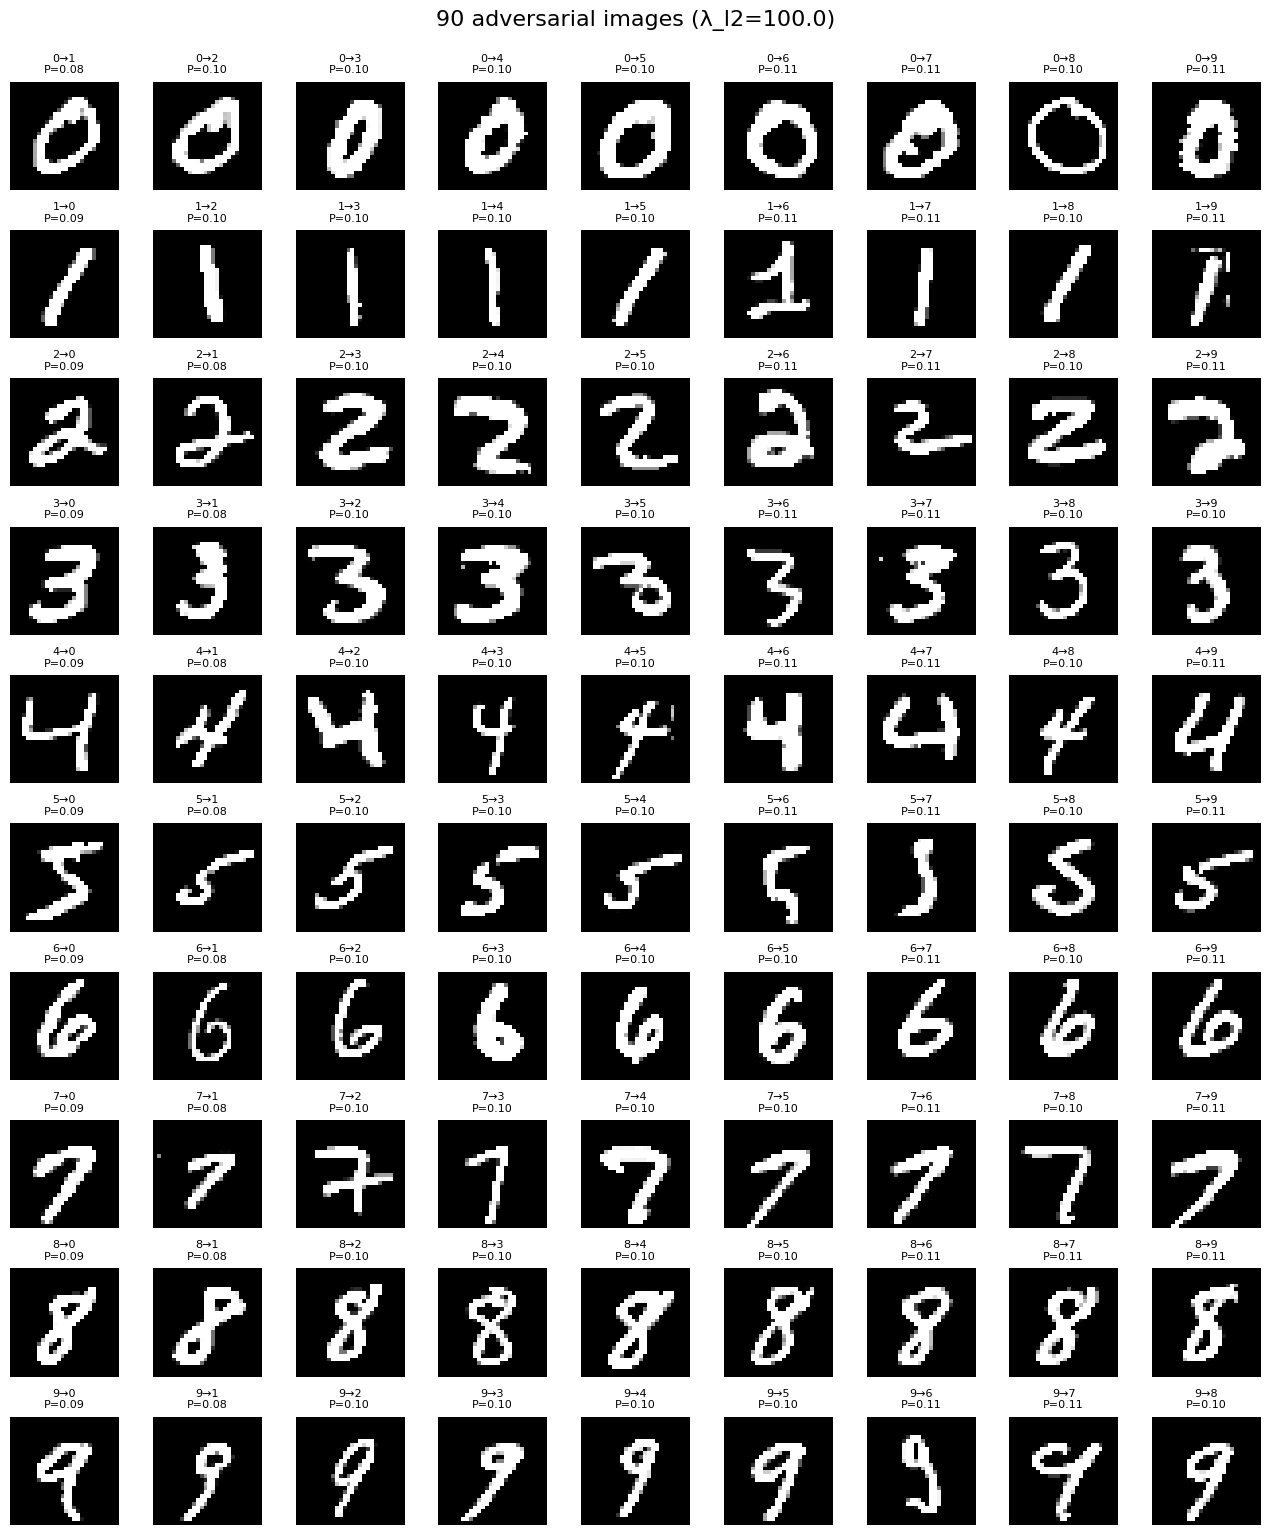

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn

# Przygotowanie danych
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Definicja LeNet5 (upewnij się, że masz wytrenowane wagi!)
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.05)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropout(x)
        return x

net = LeNet5().to(device)
# Jeśli masz zapisane wagi, załaduj je tutaj!
# net.load_state_dict(torch.load('lenet5_mnist.pth'))
net.eval()

def get_nine_per_class(device='cuda'):
    images = {i: [] for i in range(10)}
    for img, label in dataset:
        if len(images[label]) < 9:
            images[label].append(img)
        if all(len(v) == 9 for v in images.values()):
            break
    all_imgs, all_labels = [], []
    for label in range(10):
        all_imgs.extend(images[label])
        all_labels.extend([label] * 9)
    return torch.stack(all_imgs).to(device), torch.tensor(all_labels, device=device)

def generate_target_labels(true_labels):
    target_labels = []
    for label in true_labels[::9]:
        others = [i for i in range(10) if i != label.item()]
        target_labels.extend(others)
    return torch.tensor(target_labels, device=true_labels.device)

def denorm(img):
    return img * 0.3081 + 0.1307

def generate_adversarials_one_to_each(net, images, true_labels, target_labels, lambda_l2=100.0, steps=2000, device='cuda'):
    net.eval()
    adversarials = []
    probs = []
    for idx in range(len(images)):
        orig = images[idx:idx+1]
        target = target_labels[idx].item()
        delta = torch.zeros_like(orig, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=0.01)
        for step in range(steps):
            optimizer.zero_grad()
            perturbed = (orig + delta).clamp(0, 1)
            logits = net(perturbed)
            loss = F.cross_entropy(logits, torch.tensor([target], device=device)) + lambda_l2 * delta.pow(2).mean()
            loss.backward()
            optimizer.step()
            if step % 500 == 0 or step == steps-1:
                with torch.no_grad():
                    prob = F.softmax(logits, dim=1)[0, target].item()
                    print(f"img {idx+1}/90, step {step}, loss: {loss.item():.4f}, P(target): {prob:.3f}")
        adv_img = (orig + delta).detach().clamp(0, 1)
        adversarials.append(adv_img.cpu())
        with torch.no_grad():
            logits = net(adv_img.to(device))
            prob = F.softmax(logits, dim=1)[0, target].item()
            probs.append(prob)
    return adversarials, probs

def plot_adv_grid_90(orig_images, orig_labels, adv_images, target_labels, probs, lambda_l2):
    fig, axs = plt.subplots(10, 9, figsize=(13, 15))
    for i in range(10):
        for j in range(9):
            idx = i * 9 + j
            axs[i, j].imshow(denorm(adv_images[idx][0]).squeeze(), cmap='gray')
            axs[i, j].set_title(f"{orig_labels[idx].item()}→{target_labels[idx].item()}\nP={probs[idx]:.2f}", fontsize=8)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.suptitle(f"90 adversarial images (λ_l2={lambda_l2})", fontsize=16, y=1.02)
    plt.show()

# --- Użycie kodu ---
images, labels = get_nine_per_class(device=device)
target_labels = generate_target_labels(labels)
lambda_l2 = 100.0
adversarials, probs = generate_adversarials_one_to_each(
    net, images, labels, target_labels, lambda_l2=lambda_l2, steps=2000, device=device
)
plot_adv_grid_90(images.cpu(), labels.cpu(), adversarials, target_labels.cpu(), probs, lambda_l2)
